# Machine Learning LAB 1 
Course 2023/24: P. Zanuttigh, M. Caligiuri, F. Lincetto

The notebook contains some simple tasks to be performed about **classification and regression**. <br>
Complete all the **required code sections** and **answer to all the questions**. <br>

### IMPORTANT for the evaluation score:
1. **Read carefully all cells** and **follow the instructions**.
1. **Rerun all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
2. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
3. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command** - otherwise points will be deduced.
4. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

##  Classification of Stayed/Churned Customers

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB1.ipynb** otherwise your homework could get lost
<br>

**Student name**: Martina Cacciola<br>
**ID Number**: 2097476

### Dataset description

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. 
The dataset contains three features:
- **Tenure in Months**: Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age

The aim of the task is to predict if a customer will churn or not based on the three features.

<center>

![COVER](data/dataset-cover.png "COVER")

</center>

We first **import** all **the packages** that are needed.

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing

Change some global settings for layout purposes.

In [3]:
# if you are in the jupyter notebook environment you can change the 'inline' option with 'notebook' to get interactive plots
%matplotlib notebook
# change the limit on the line length and crop to 0 very small numbers, for clearer printing
np.set_printoptions(linewidth=500, suppress=True)

## A) Perceptron
In the following cells we will **implement** the **perceptron** algorithm and use it to learn a halfspace.

**TO DO (A.0):** **Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [4]:
IDnumber = 2097476 # YOUR_ID
np.random.seed(IDnumber)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (the **training** set is **typically larger**, here we use a 75% training 25% test split).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above. Try different seeds to evaluate the impact of randomization.<br><br>
**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

### The Dataset
The dataset is a `.csv` file containing three input features and a label. Here is an example of the first 4 rows of the dataset: 

<center>

Tenure in Months | Monthly Charge | Age | Customer Status |
| -----------------| ---------------|-----|-----------------|
| 9 | 65.6 | 37 | 0 |
| 9 | -4.0 | 46 | 0 |
| 4 | 73.9 | 50 | 1 |
| ... | ... | ... | ... |

</center>

Customer Status is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [5]:
def load_dataset(filename):
    data_train = pd.read_csv(filename)
    #permute the data
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffle the data
    X = data_train.iloc[:, 0:3].values # Get first two columns as the input
    Y = data_train.iloc[:, 3].values # Get the third column as the label
    Y = 2*Y-1 # Make sure labels are -1 or 1 (0 --> -1, 1 --> 1)
    return X,Y

In [6]:
# Load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

We are going to differentiate (classify) between **class "1" (churned)** and **class "-1" (stayed)**

# Split data in training and test sets



Given $m$ total data, denote with $m_{t}$ the part used for training. Keep $m_t$ data as training data, and $m_{test}:= m-m_{t}$. <br>
For instance one can take $m_t=0.75m$ of the data as training and $m_{test}=0.25m$ as testing. <br>
Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the empirical loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat{h} = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

TESTING DATA: The test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$

**TO DO (A.1):** **Divide** the **data into training and test set** (**75%** of the data in the **first** set, **25%** in the **second** one). <br>
<br>
Notice that as is common practice in Statistics and Machine Learning, **we scale the data** (= each variable) so that it is centered **(zero mean)** and has **standard deviation equal to 1**. <br>
This helps in terms of numerical conditioning of the (inverse) problems of estimating the model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients.

In [7]:
#size of the training set
m_training = int(0.75 * len(X))

# m_test is the number of samples in the test set (total-training)
m_test = len(X) - m_training

# X_training = instances for training set
X_training = X[:m_training]
# Y_training = labels for the training set
Y_training =  Y[:m_training]

# X_test = instances for test set
X_test =  X[:m_test]
# Y_test = labels for the test set
Y_test =  Y[:m_test]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\nNumber of night instances in test:", np.sum(Y_test==-1))
print("Number of day instances in test:", np.sum(Y_test==1))

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test =  scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 2817
Number of samples in the test set: 940

Number of night instances in test: 491
Number of day instances in test: 449
Mean of the training input data: [-0.  0.  0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [ 0.00072996  0.0334437  -0.03659371]
Std of the test input data: [0.97627702 0.96910858 0.99422846]


We **add a 1 in front of each sample** so that we can use a vector in **homogeneous coordinates** to describe all the coefficients of the model. This can be done with the function $hstack$ in $numpy$.

In [8]:
def to_homogeneous(X_training, X_test):
    # Add a 1 to each sample (homogeneous coordinates)
    X_training = np.hstack( [np.ones( (X_training.shape[0], 1) ), X_training] )
    X_test = np.hstack( [np.ones( (X_test.shape[0], 1) ), X_test] )
    
    return X_training, X_test

In [9]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.          0.35284357  0.08480802  1.5079441 ]
 [ 1.          0.76949362  1.25782368  0.56459999]
 [ 1.         -0.89710656  0.42902629  1.15419006]
 [ 1.         -0.48045652 -1.60286408 -0.90937518]
 [ 1.          0.85282363 -0.82085364 -0.43770313]
 [ 1.          0.89448863  0.5977935   0.91835403]
 [ 1.          1.47779869  1.18764325  1.03627205]
 [ 1.          0.47783859  1.53687441 -0.37874412]
 [ 1.         -0.39712651  0.09483379 -0.02499008]
 [ 1.          1.76945372  1.56528077  0.32876396]]


**TO DO (A.2):** Now **complete** the function *perceptron*. <br>
The **perceptron** algorithm **does not terminate** if the **data** is not **linearly separable**, therefore your implementation should **terminate** if it **reached the termination** condition seen in class **or** if a **maximum number of iterations** have already been run, where one **iteration** corresponds to **one update of the perceptron weights**. In case the **termination** is reached **because** the **maximum** number of **iterations** have been completed, the implementation should **return the best model** seen throughout .

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model (or the latest, if the termination condition is reached)
- $best\_error$: the *fraction* of misclassified samples for the best model

In [10]:
def count_errors(current_w, X, Y):
    # This function:
    # computes the number of misclassified samples
    # returns the index of all misclassified samples
    # if there are no misclassified samples, returns -1 as index
  
    #define misclassified samples
    is_misclassified = np.where(np.sign(X.dot(current_w)) != Y)[0]
    
    #the following returns the number of misclassified samples and the index of the first of the first misclassified sample
    if len(is_misclassified) == 0:
        return 0, -1
    else:
        return len(is_misclassified), is_misclassified[0]

    
def perceptron_update(current_w, x, y):
    # Place in this function the update rule of the perceptron algorithm
    # Remember that numpy arrays can be treated as generalized variables
    # therefore given array a = [1,2,3,4], the operation b = 10*a will yield
    # b = [10, 20, 30, 40]
    new_w = current_w + y*x
    return new_w

def perceptron_no_randomization(X, Y, max_num_iterations):
    
    # Initialize some support variables
    num_samples = X.shape[0]
    # best_errors will keep track of the best (minimum) number of errors
    # seen throughout training, used for the update of the best_w variable
    best_error = num_samples+1
    
    # Initialize the weights of the algorithm with w=0
    curr_w = np.zeros(X.shape[1])
    # The best_w variable will be used to keep track of the best solution
    best_w = curr_w.copy()

    # compute the number of misclassified samples and the index of the first of them
    num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
    # update the 'best' variables
    if num_misclassified < best_error:
        best_error = num_misclassified
        best_w = curr_w.copy()
    
    # initialize the number of iterations
    num_iter = 0
    # Main loop continue until all samples correctly classified or max # iterations reached
    # Remember that to signify that no errors were found we set index_misclassified = -1
    while index_misclassified != -1 and num_iter < max_num_iterations:
              
        #update the weights if a sample is misclassified as defined before
        curr_w = perceptron_update(curr_w, X[index_misclassified], Y[index_misclassified])
        
        num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
        
        #choose the misclassified sample with the lowest index at each iteration
        if num_misclassified < best_error:
            best_error = num_misclassified
            best_w = curr_w.copy()
            
        #go to next iteration
        num_iter += 1

    # as required, return the best error as a ratio with respect to the total number of samples
    best_error = best_error/num_samples
    
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 30 iterations and print the error of the best model we have found.

In [11]:
# Now run the perceptron for 100 iterations
w_found, error = perceptron_no_randomization(X_training,Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error))

Training Error of perceptron (30 iterations): 0.25026624068157616


**TO DO (A.3):** use the best model $w\_found$ to **predict the labels for the test dataset** and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [12]:
errors, _ = count_errors(w_found, X_test,Y_test)

true_loss_estimate = errors/m_test     # Error rate on the test set

# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))

Test Error of perceptron (30 iterations): 0.23829787234042554


**TO DO (A.4):** implement the correct randomized version of the perceptron such that at each iteration the algorithm picks a random misclassified sample and updates the weights using that sample.

In [13]:
def perceptron(X, Y, max_num_iterations):
    num_samples = X.shape[0]
    best_error = num_samples + 1
    curr_w = np.zeros(X.shape[1])
    best_w = curr_w.copy()
    
    num_iter = 0
    while num_iter < max_num_iterations:
        #permutation of indices
        perm = np.random.permutation(num_samples)
        
        #shuffle X and Y
        X = X[perm]
        Y = Y[perm]
        
        misclassified_indices = np.where(np.sign(X.dot(curr_w)) != Y)[0]
        
        #when all samples are correctly classified
        if len(misclassified_indices) == 0:
            break 
        
        #randomly select a misclassified sample
        random_index = np.random.randint(0, len(misclassified_indices))
        x_misclassified = X[random_index]
        y_misclassified = Y[random_index]
        
        #update weights using the selected misclassified sample
        curr_w = perceptron_update(curr_w, x_misclassified, y_misclassified)
        
        num_misclassified = len(misclassified_indices)
        
        if num_misclassified < best_error:
            best_error = num_misclassified
            best_w = curr_w.copy()
        
        num_iter += 1
    
    best_error = best_error / num_samples
    return best_w, best_error

**TO DO (A.5):** Now test the correct version of the perceptron using 30 iterations and print the error of the best model we have found.

In [14]:
# Now run the perceptron for 30 iterations
w_found, error = perceptron(X_training,Y_training, 30)
print("Training Error of perceptron (30 iterations): " + str(error))

errors, _ = count_errors(w_found, X_test,Y_test)

true_loss_estimate = errors/m_test      # Error rate on the test set
# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (30 iterations): " + str(true_loss_estimate))

Training Error of perceptron (30 iterations): 0.25133120340788073
Test Error of perceptron (30 iterations): 0.274468085106383


**TO DO (A.Q1) [Answer the following]** <br>
What is the difference between the two versions of the perceptron? Can you explain why there is this difference? <br>

<div class="alert alert-block alert-info">
**ANSWER A.Q1**:<br>
In the non-randomized version, the perceptron works on samples in a fixed order, starting from the first sample and iterating sequencially through the dataset. If there is some inherent structure or pattern in the data, the first version may be influenced by the order in which samples are presented. 
    
In the randomized version, the samples are shuffled before each iteration, so the order in which they are processed is random. This can help in avoiding the introduction of any bias, leading to a more robust algorithm. 
    
In our case, both the training and the test error for the randomized perceptron are slightly greater than those in the previous implementation. This might not be a negative fact, since it could indicate that we are reaching a better generalized solution with less probability of getting stuck in local optima.
 </div>

### Now consider only a the random version of the perceptron

**TO DO (A.Q2) [Answer the following]** <br>
What about the difference between the training error and the test error  in terms of fraction of misclassified samples? Explain what you observe. (Notice that with a very small dataset like this one results can change due to randomization, try to run with different random seeds if you get unexpected results).

<div class="alert alert-block alert-info">
**ANSWER A.Q2**:<br>
What we can infer from the results is that the difference between the two quantities is small, with the test error being slightly larger than the training error. This suggests that the algorithm is likely generalizing well to new data and is not overfitting severely to the training data. 
    
Since the test set is made of samples that the model has not seen during training, a small increase in the error might be expected.
 </div>

<IPython.core.display.Javascript object>


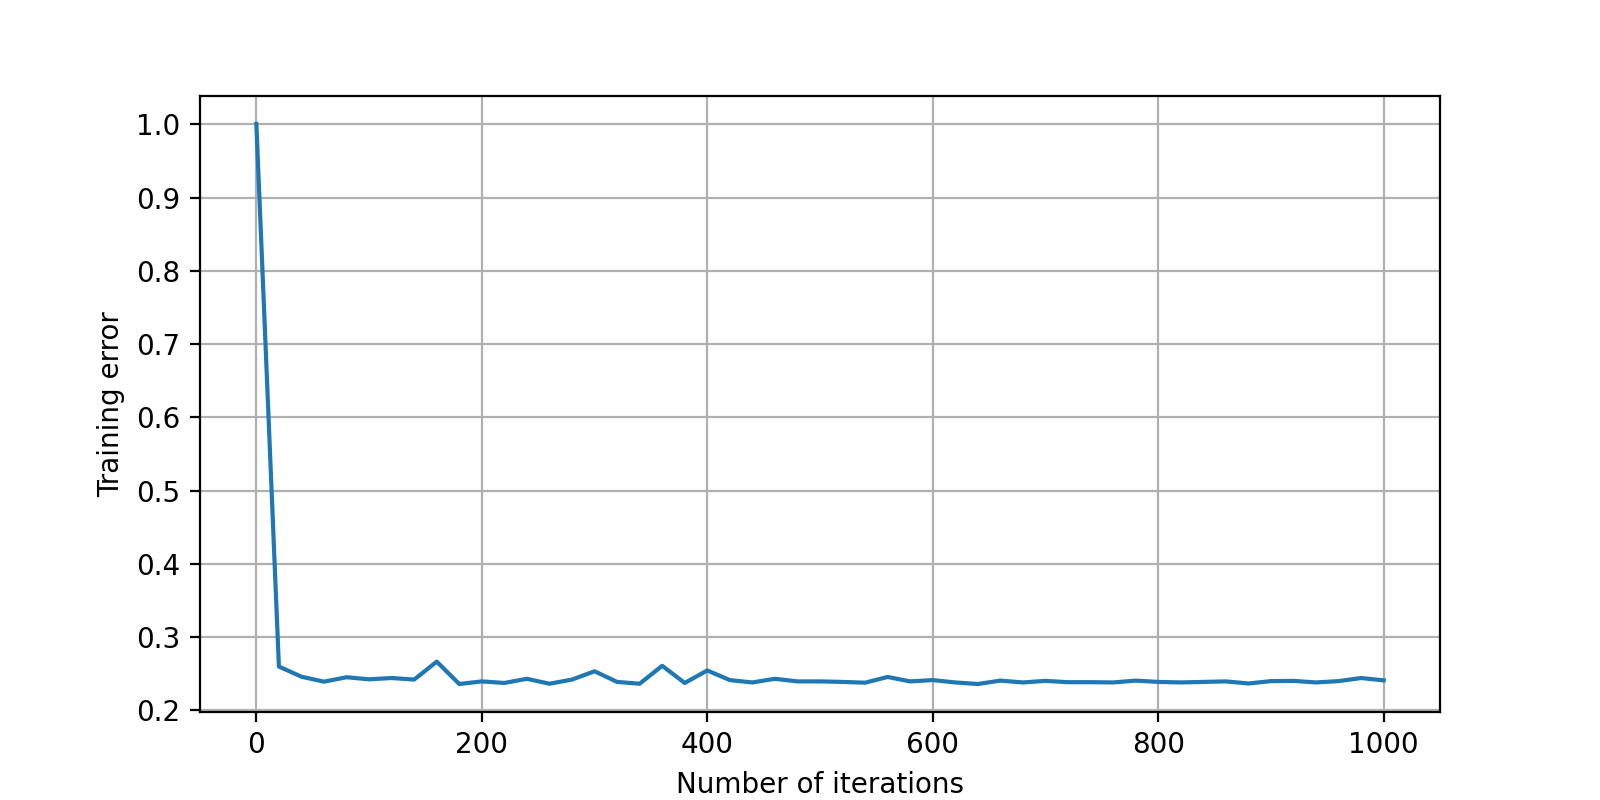

In [15]:
# Plot the loss with respect to the number of iterations
plt.figure(figsize=(8,4))

num_iters = np.arange(0, 1001, 20)
errors = []

for num_iter in num_iters:
    _, error = perceptron(X_training, Y_training, num_iter)
    errors.append(error)

plt.plot(num_iters, errors)
plt.xlabel('Number of iterations')
plt.ylabel('Training error')
plt.grid()
plt.show()

# NOTE how the training loss decreases as we increase the number of iterations

**TO DO (A.6):** Copy the code from the last 2 cells above in the cell below and repeat the training with 3000 iterations. Then print the error in the training set and the estimate of the true loss obtained from the test set.

In [16]:
# Now run the perceptron for 30 iterations
w_found, error = perceptron(X_training,Y_training, 3000)
print("Training Error of perceptron (3000 iterations): " + str(error))

errors, _ = count_errors(w_found, X_test,Y_test)

true_loss_estimate = errors/m_test      # Error rate on the test set

print("Test Error of perceptron (3000 iterations): " + str(true_loss_estimate))

Training Error of perceptron (3000 iterations): 0.23961661341853036
Test Error of perceptron (3000 iterations): 0.24148936170212765


<IPython.core.display.Javascript object>


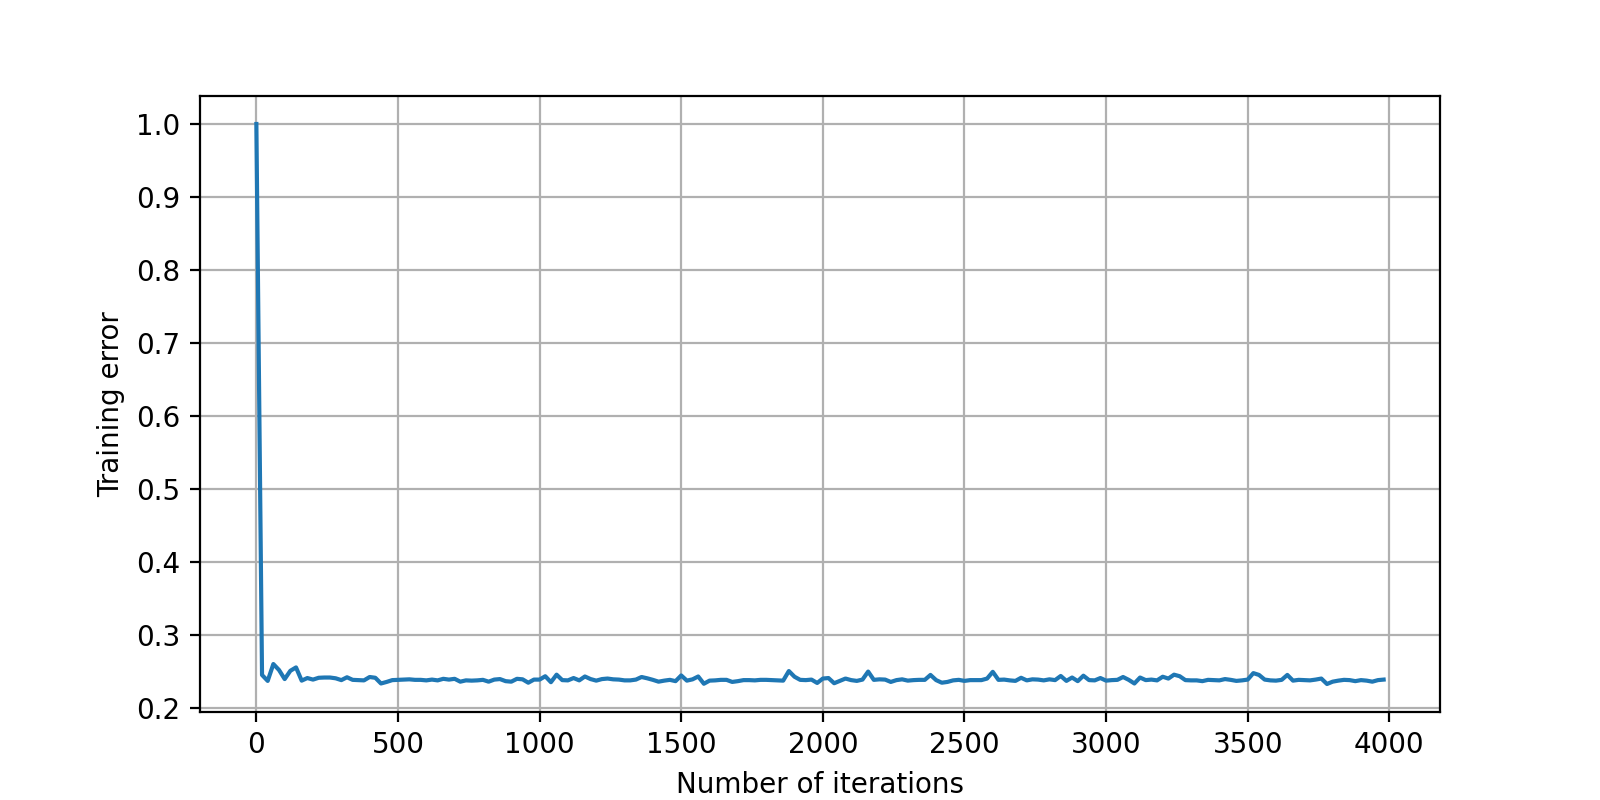

In [17]:
# Plot the loss with respect to the number of iterations
plt.figure(figsize=(8,4))

num_iters = np.arange(0, 4000, 20)
errors = []

for num_iter in num_iters:
    _, error = perceptron(X_training, Y_training, num_iter)
    errors.append(error)

plt.plot(num_iters, errors)
plt.xlabel('Number of iterations')
plt.ylabel('Training error')
plt.grid()
plt.show()

**TO DO (A.Q3) [Answer the following]** <br>
What about the difference between the training error and the test error in terms of the fraction of misclassified samples) when running for a larger number of iterations? Explain what you observe and compare with the previous case.

<div class="alert alert-block alert-info">
**ANSWER A.Q3**:<br>
When increasing the number of iterations, we denote a decrease in the training error, indicating a better performance of the model in fitting the training data and learning patterns from them. There is also a reduction of the test error, meaning that the algorithm is generalizing reasonably well to the test set.  
    
The difference between training and test errors has reduced from the previous case.
This suggests that the model's performance has improved, with both training and test errors converging to relatively low values.
</div>

# B) Logistic Regression
Now we use **logistic regression**, exploiting the implementation in **Scikit-learn**, to predict labels. We will also plot the decision boundaries of logistic regression.

We first load the dataset again.

To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. <br>
See the Scikit-learn documentation for how to use it [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**TO DO (B.1):** **Define** the **logistic regression** model, then **learn** the model using **the training set** and **predict** on the **test set**. Then **print** the **fraction of samples misclassified** in the training set and in the test set.

In [18]:
# part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C=1e5) # C should be very large to ignore regularization (see above)

# learn from training set: hint use fit(...)
logreg.fit(X_training,Y_training)
print("Intercept:" , logreg.intercept_)
print("Coefficients:" , logreg.coef_)

# predict on training set
predicted_training = logreg.predict(X_training)

# print the error rate = fraction of misclassified samples
error_count_training = (predicted_training != Y_training).sum()
error_rate_training = error_count_training/m_training
print("Error rate on training set: "+str(error_rate_training))

# predict on test set
predicted_test = logreg.predict(X_test)

#print the error rate = fraction of misclassified samples
error_count_test = (predicted_test != Y_test).sum()
error_rate_test = error_count_test/m_test
print("Error rate on test set: " + str(error_rate_test))

Intercept: [-0.04755896]
Coefficients: [[-0.04755895 -1.48434294  0.82943541  0.26640931]]
Error rate on training set: 0.24245651402200924
Error rate on test set: 0.24893617021276596


**TO DO (B.2)** Now **pick two features** and restrict the dataset to include only two features, whose indices are specified in the $idx0$ and $idx1$ variables below. Then split into training and test.

In [19]:
feature_names  = ["Tenure in Months","Monthly Charge","Age"]

# Select the two features to use
idx0 = 0
idx1 = 1

X_reduced = X[:,[idx0, idx1]]

# re-initialize the dataset splits, with the reduced sets
X_training = X_reduced[:m_training]
Y_training = Y[:m_training]

X_test = X_reduced[m_training:]
Y_test = Y[m_training:]

Now learn a model using the training data and measure the performances.

In [20]:
# learning from training data
logreg.fit(X_training,Y_training)
# predict on test set
predicted_test = logreg.predict(X_test)

#print the error rate = fraction of misclassified samples
error_count_test = (predicted_test != Y_test).sum()

# print the error rate = fraction of misclassified samples
error_rate_test = error_count_test/m_test
print("Error rate on test set: " + str(error_rate_test))

Error rate on test set: 0.25851063829787235


**TO DO (B.Q1) [Answer the following]** <br>
Which features did you select and why? <br>
Compare the perfomance of the classifiers trained with every combination of two features with that of the baseline (which used all 3 features).

In [24]:
#per niente convinta

<div class="alert alert-block alert-info">
**ANSWER B.Q1**:<br>
Since the goal is to predict whether a customer will churn or not, the pair of features ("Tenure in Months" and "Monthly Charge") could be insightful: customers who have been with the company for a longer time might have different behaviors compared to new customers, and the monthly charge could be indicative of their subscription level.
</div>

Classifier: perceptron_no_randomization
Features: Tenure in Months, Monthly Charge
Training Error: 0.49378771742988997
Test Error: 0.4957446808510638

Features: Tenure in Months, Age
Training Error: 0.27121050763223287
Test Error: 0.30106382978723406

Features: Monthly Charge, Age
Training Error: 0.49378771742988997
Test Error: 0.5148936170212766

Features: Tenure in Months, Monthly Charge, Age
Training Error: 0.4849130280440185
Test Error: 0.5127659574468085

Classifier: perceptron
Features: Tenure in Months, Monthly Charge
Training Error: 0.2470713525026624
Test Error: 0.451063829787234

Features: Tenure in Months, Age
Training Error: 0.324103656372027
Test Error: 0.4117021276595745

Features: Monthly Charge, Age
Training Error: 0.4923677671281505
Test Error: 0.4978723404255319

Features: Tenure in Months, Monthly Charge, Age
Training Error: 0.4323748668796592
Test Error: 0.4925531914893617

Classifier: LogisticRegression
Features: Tenure in Months, Monthly Charge
Training Error: 0.2

<IPython.core.display.Javascript object>


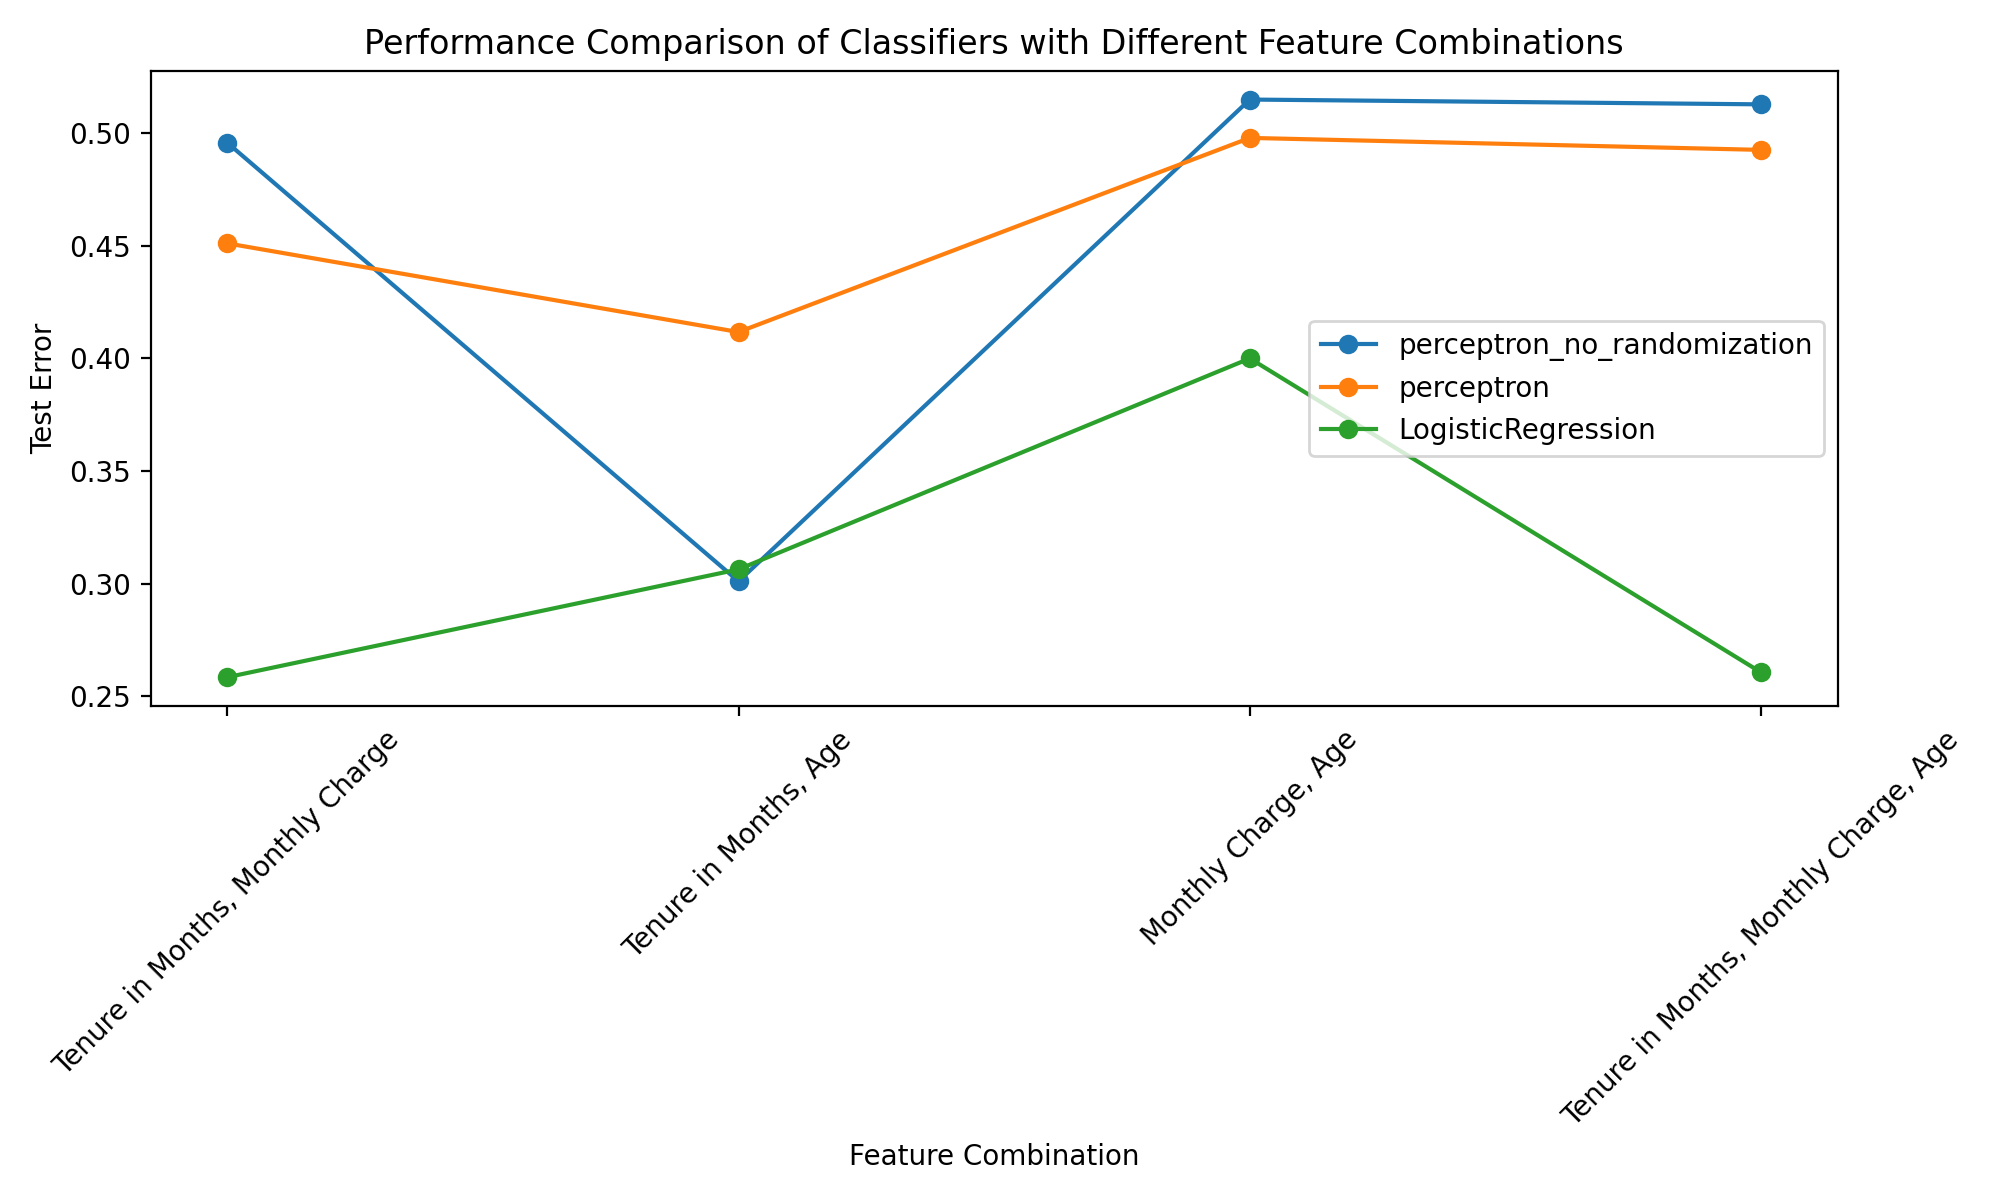

In [23]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

classifiers = {
    "perceptron_no_randomization": perceptron_no_randomization,
    "perceptron": perceptron,
    "LogisticRegression": LogisticRegression
}

feature_combinations = [(0, 1), (0, 2), (1, 2), (0, 1, 2)]

#initialize lists to store error rates for each classifier and feature combination
training_errors = {classifier_name: [] for classifier_name in classifiers}
test_errors = {classifier_name: [] for classifier_name in classifiers}

#for each classifier
for classifier_name, classifier in classifiers.items():
    print(f"Classifier: {classifier_name}")
    
    #for each feature combination
    for feature_combination in feature_combinations:
        print(f"Features: {', '.join(feature_names[i] for i in feature_combination)}")
        
        X_reduced = X[:, feature_combination]

        X_training = X_reduced[:m_training]
        Y_training = Y[:m_training]

        X_test = X_reduced[m_training:]
        Y_test = Y[m_training:]

        #train the classifier
        if classifier_name in ["perceptron_no_randomization", "perceptron"]:
            w_found, training_error = classifier(X_training, Y_training, 30)
            print(f"Training Error: {training_error}")
            
            errors, _ = count_errors(w_found, X_test, Y_test)
            test_error = errors / len(X_test)
            print(f"Test Error: {test_error}")
        else:
            model = classifier(C=1e5).fit(X_training, Y_training)
            training_error = 1 - model.score(X_training, Y_training)
            print(f"Training Error: {training_error}")
            
            test_error = 1 - model.score(X_test, Y_test)
            print(f"Test Error: {test_error}")
        
        training_errors[classifier_name].append(training_error)
        test_errors[classifier_name].append(test_error)
        
        print()

        
plt.figure(figsize=(10, 6))

for classifier_name in classifiers:
    plt.plot(range(len(feature_combinations)), test_errors[classifier_name], label=classifier_name, marker='o')

plt.xticks(range(len(feature_combinations)), [', '.join(feature_names[i] for i in fc) for fc in feature_combinations], rotation=45)
plt.xlabel('Feature Combination')
plt.ylabel('Test Error')
plt.legend()
plt.title('Performance Comparison of Classifiers')
plt.tight_layout()
plt.show()